In [1]:
# Import modules
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
from rasterio import features
from rasterio.enums import MergeAlg
from rasterio.plot import show
import numpy as np

In [2]:
# Read in vector
vector = gpd.read_file(r"../_static/e_vector_shapefiles/sf_bay_counties/sf_bay_counties.shp")

# Get list of geometries for all features in vector file
geom = [shapes for shapes in vector.geometry]

# Open example raster
raster = rasterio.open(r"../_static/e_raster/bay-area-wells_kde_sklearn.tif")

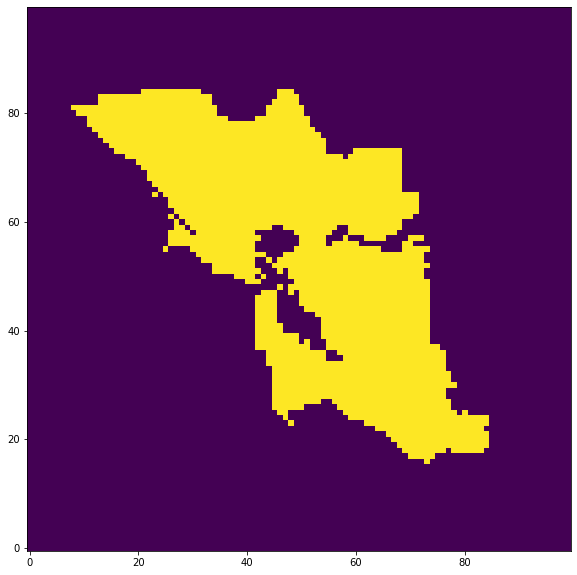

In [3]:
# Rasterize vector using the shape and coordinate system of the raster
rasterized = features.rasterize(geom,
                                out_shape = raster.shape,
                                fill = 0,
                                out = None,
                                transform = raster.transform,
                                all_touched = False,
                                default_value = 1,
                                dtype = None)

# Plot raster
fig, ax = plt.subplots(1, figsize = (10, 10))
show(rasterized, ax = ax)
plt.gca().invert_yaxis()

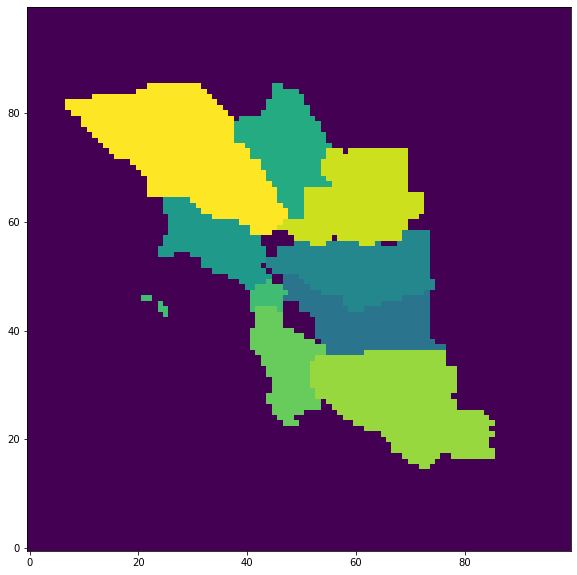

In [4]:
# create a numeric unique value for each row
vector['id'] = range(0,len(vector))

# create tuples of geometry, value pairs, where value is the attribute value you want to burn
geom_value = ((geom,value) for geom, value in zip(vector.geometry, vector['id']))

# Rasterize vector using the shape and transform of the raster
rasterized = features.rasterize(geom_value,
                                out_shape = raster.shape,
                                transform = raster.transform,
                                all_touched = True,
                                fill = -5,   # background value
                                merge_alg = MergeAlg.replace,
                                dtype = np.int16)

# Plot raster
fig, ax = plt.subplots(1, figsize = (10, 10))
show(rasterized, ax = ax)
plt.gca().invert_yaxis()

In [5]:
with rasterio.open(
        "../temp/rasterized_vector.tif", "w",
        driver = "GTiff",
        transform = raster.transform,
        dtype = rasterio.uint8,
        count = 1,
        width = raster.width,
        height = raster.height) as dst:
    dst.write(rasterized, indexes = 1)